In [85]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice

%matplotlib widget
plt.style.use('presentation.mplstyle')


In [2]:
all_analysis_folders = get_analysis_folders()


In [64]:
plates = [52,84,94,152,102,76,83]

analysis_folders = all_analysis_folders.loc[all_analysis_folders['Plate'].isin(plates)]

In [65]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)

C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\84_20220621\Analysis_84_20220621_200_Version1\time_hypha_info\hyph_info_174.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\84_20220621\Analysis_84_20220621_200_Version1\time_hypha_info\hyph_info_175.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\84_20220621\Analysis_84_20220621_200_Version1\time_hypha_info\hyph_info_179.json


In [66]:
def select_movement(plate,time_hypha_info,min_num_occ =4):
    time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]
    select = time_hypha_plate
    max_speeds = select.groupby('end').max()['speed']
    correct_tracks = max_speeds.loc[max_speeds<=450]
    select = select.loc[select['end'].isin(correct_tracks.index)]
    select = select.loc[select['distance_final_pos']>=400]
    select = select.loc[select['speed'].between(50,400)]
    select = select.loc[select['in_ROI']=='True']
    num_occ = select.groupby('end').count()['speed']
    correct_tracks = num_occ.loc[num_occ>=min_num_occ]
    select = select.loc[select['end'].isin(correct_tracks.index)]
    select_movements = select 
    return(select_movements)

def get_average_time_data(plate,time_hypha_info):
    select_movements = select_movement(plate,time_hypha_info)
    group =select_movements.groupby(['time_since_begin_h'])['speed']
    data = group.median()
    dy = group.std()/np.sqrt(group.count())

    return(data,dy,select_movements)

In [67]:
plate = 94
global_hypha_plate = global_hypha_info.loc[global_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]
select_movements = select_movement(plate,time_hypha_info,1)
hyphae_select = select_movements['end'].unique()
select_hypha = global_hypha_plate.loc[global_hypha_plate['index'].isin(hyphae_select)]
len(global_hypha_plate),len(select_hypha)

(8014, 917)

In [68]:
select_hypha.groupby('timestep_anastomosis').count()['index'].loc[1:]

timestep_anastomosis
4       1
16      1
17      1
23      1
26      1
       ..
160    17
161    14
162    26
163     9
164     2
Name: index, Length: 114, dtype: int64

(0.0, 10.0)

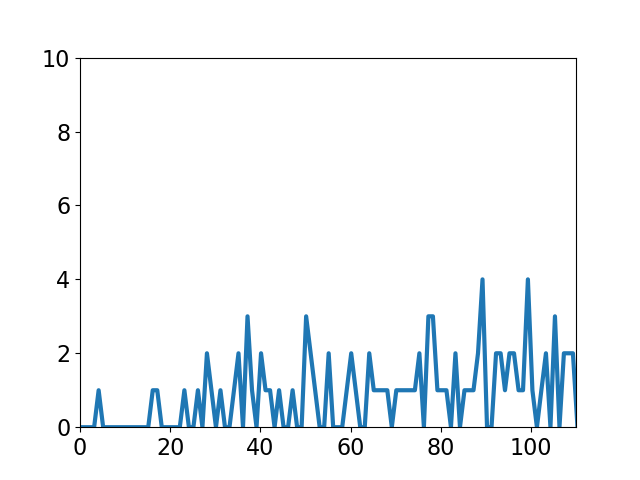

In [69]:
time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]
time_plate_info_plate = time_plate_info_plate.set_index('timestep')
time_plate_info_plate['num_anastomosis'] = select_hypha.groupby('timestep_anastomosis').count()['index'].loc[1:]
time_plate_info_plate['num_anastomosis'] = time_plate_info_plate['num_anastomosis'].fillna(0)
time_plate_info_plate = time_plate_info_plate.sort_values('time_since_begin_h')
fig,ax = plt.subplots()
ax.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['num_anastomosis'])
# time_plate_info_plate['num_anastomosis'] = global_hypha_plate.groupby('timestep_anastomosis').count()['index'].loc[1:]
# time_plate_info_plate['num_anastomosis'] = time_plate_info_plate['num_anastomosis'].fillna(0)
# ax.scatter(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['num_anastomosis'])
ax.set_xlim(0,110)
ax.set_ylim(0,10)

In [70]:
tables = {plate : time_plate_info.loc[time_plate_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)].copy() for plate in plates}

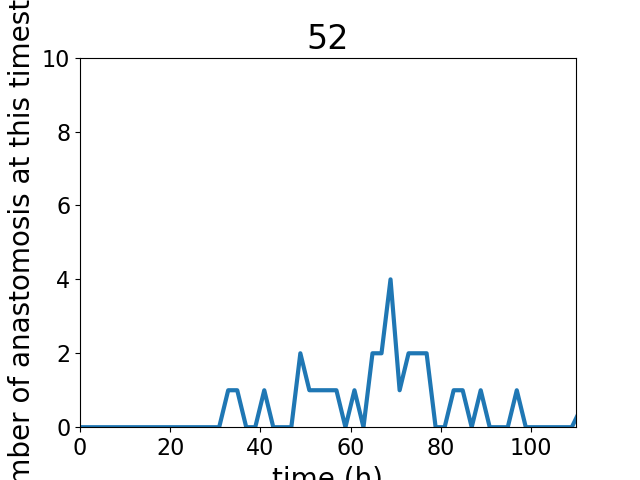

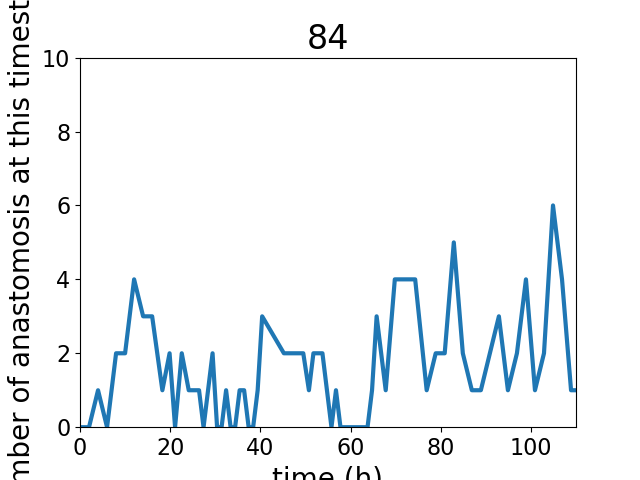

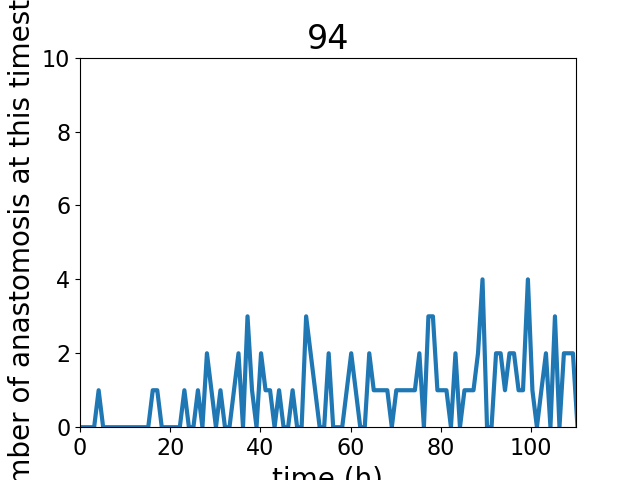

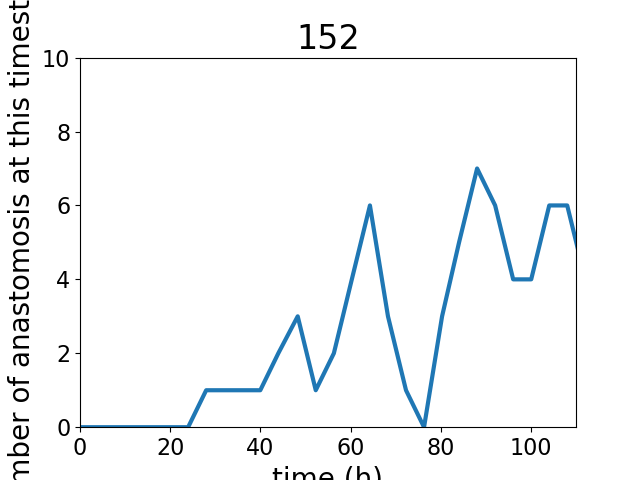

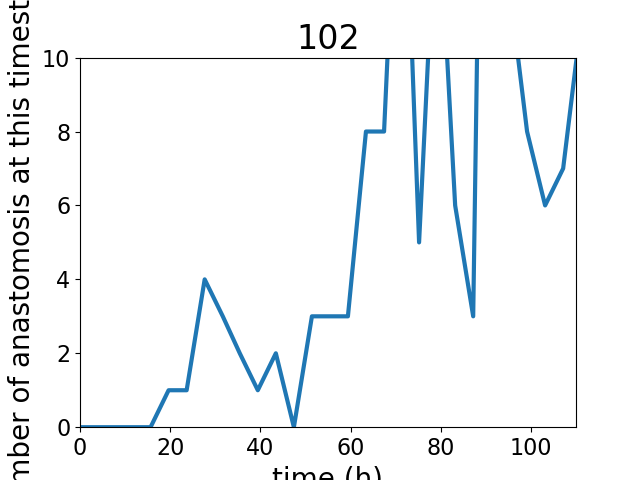

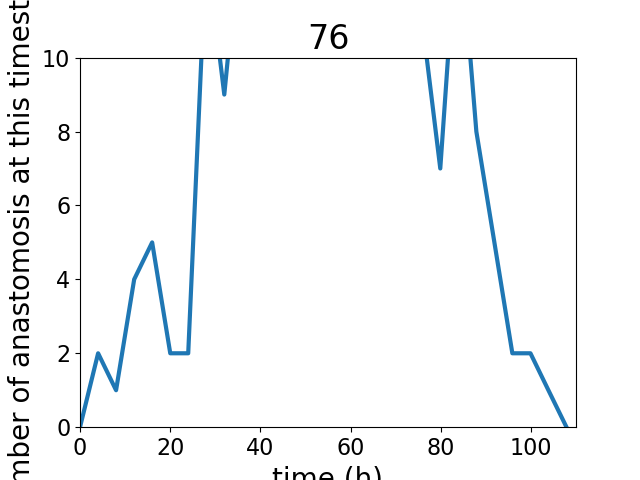

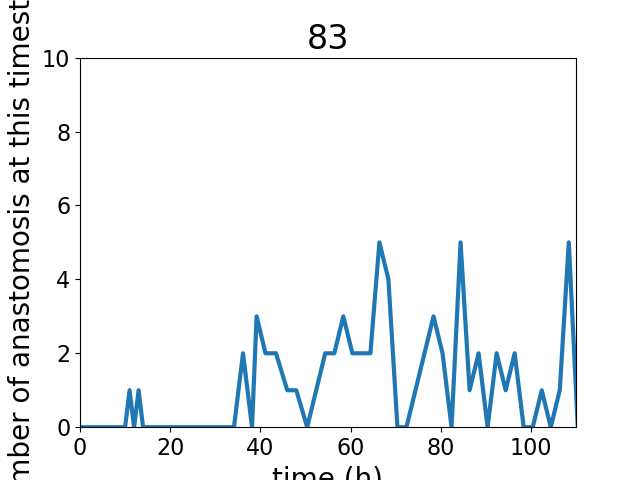

In [71]:
for plate in plates:
    global_hypha_plate = global_hypha_info.loc[global_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]
    select_movements = select_movement(plate,time_hypha_info,1)
    hyphae_select = select_movements['end'].unique()
    select_hypha = global_hypha_plate.loc[global_hypha_plate['index'].isin(hyphae_select)]
    time_plate_info_plate = tables[plate]
    time_plate_info_plate = time_plate_info_plate.set_index('timestep')
    time_plate_info_plate = time_plate_info_plate.sort_values("time_since_begin_h")
    time_plate_info_plate['num_anastomosis'] = select_hypha.groupby('timestep_anastomosis').count()['index'].loc[1:]
    time_plate_info_plate['num_anastomosis'] = time_plate_info_plate['num_anastomosis'].fillna(0)
    tables[plate] = time_plate_info_plate
    fig,ax = plt.subplots()
    ax.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['num_anastomosis'])
    ax.set_xlim(0,110)
    ax.set_ylim(0,10)
    ax.set_title(f'{plate}')
    ax.set_xlabel('time (h)')
    ax.set_ylabel('number of anastomosis at this timestep')

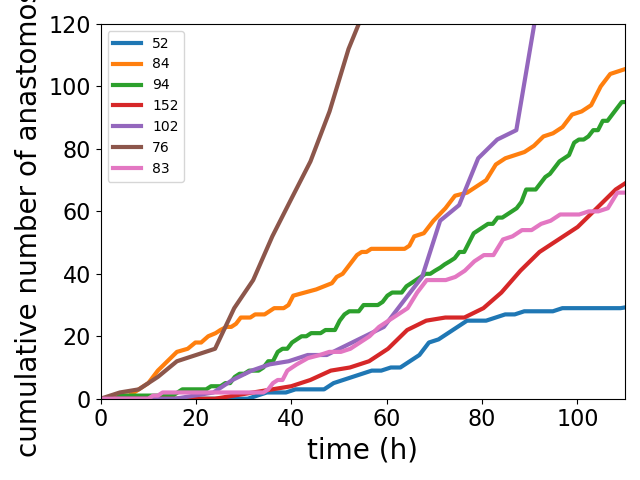

In [74]:
fig,ax = plt.subplots()
for plate in plates:
    time_plate_info_plate = tables[plate]
    ax.plot(time_plate_info_plate['time_since_begin_h'],np.cumsum(time_plate_info_plate['num_anastomosis']),label=plate)
    ax.set_xlim(0,110)
    ax.set_ylim(0,120)
plt.legend() 
ax.set_xlabel('time (h)')
ax.set_ylabel('cumulative number of anastomosis')
plt.tight_layout()

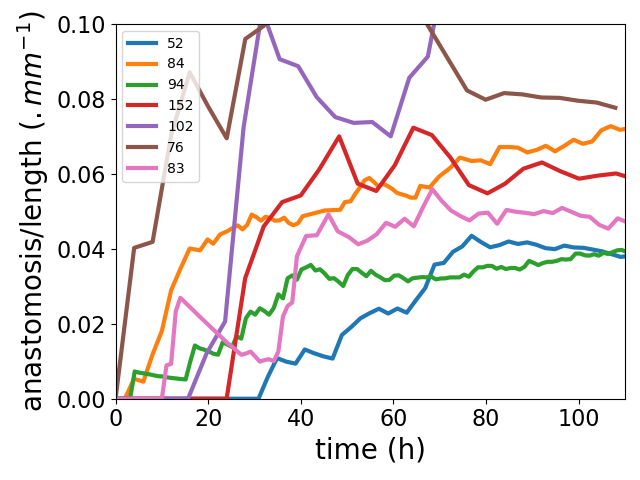

In [79]:
fig,ax = plt.subplots()
for plate in plates:
    time_plate_info_plate = tables[plate]
    ax.plot(time_plate_info_plate['time_since_begin_h'],np.cumsum(time_plate_info_plate['num_anastomosis'])/time_plate_info_plate['tot_length_study']*1000,label=plate)
    ax.set_xlim(0,110)
    ax.set_ylim(0,1e-1)
plt.legend() 
ax.set_xlabel('time (h)')
ax.set_ylabel('anastomosis/length $(.mm^{-1}$)')
plt.tight_layout()

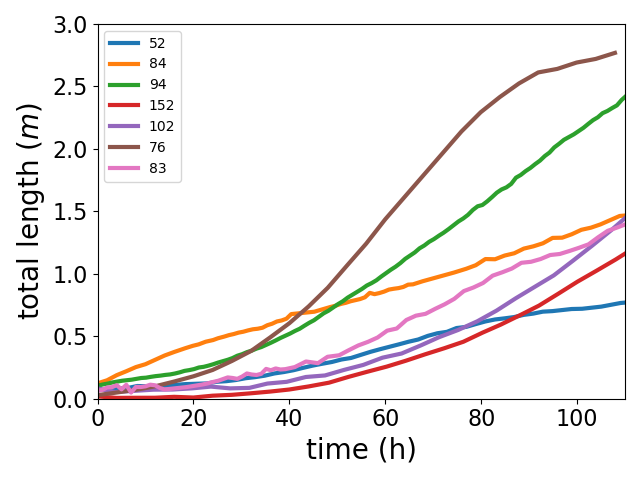

In [84]:
fig,ax = plt.subplots()
for plate in plates:
    time_plate_info_plate = tables[plate]
    ax.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['tot_length_study']/1e6,label=plate)
    ax.set_xlim(0,110)
    ax.set_ylim(0,3)
plt.legend() 
ax.set_xlabel('time (h)')
ax.set_ylabel('total length ($m$)')
plt.tight_layout()